In [7]:
import pandas as pd
from hyperopt import hp

In [8]:
import helpers, models
from helpers import pipeline
from models import TFBertweetClassifier, BertweetClassifier, BaselineModel, Ensemble

In [9]:
# parameters
FULL = False
SEED = 42
TEST_SIZE = 0.3

In [10]:
# run for main model

MODEL_CLASS = BertweetClassifier
MODEL_ARGS = {
    'manual_seed': 69,
    'num_train_epochs': 1,
    'train_batch_size': 16,
    'learning_rate': 2e-5, 
    'dropout': 0.1,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'optimizer': 'AdamW',
    'overwrite_output_dir': True,
}
OUT_PATH = 'submission.csv'

pipeline(
    full=FULL,
    seed=SEED,
    test_size=TEST_SIZE,
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    out_path=OUT_PATH
)

In [11]:
# run for baseline model

BASELINE_MODEL_CLASS = BaselineModel
BASELINE_MODEL_ARGS = {'n': 2, 'p': 0.25}

pipeline(
    full=FULL,
    seed=SEED,
    test_size=TEST_SIZE,
    model_class=BASELINE_MODEL_CLASS,
    model_args=BASELINE_MODEL_ARGS
)

Training accuracy: 95.86%
Testing accuracy: 80.03%


In [12]:
# extra small dataset

TRAIN_SIZE_XS = 10000

X_train, y_train, X_test, y_test = helpers.get_data(False, 42, 0.3)
X_train_xs, y_train_xs = X_train[:TRAIN_SIZE_XS], y_train[:TRAIN_SIZE_XS]
X_test_xs, y_test_xs = X_test[:TRAIN_SIZE_XS], y_test[:TRAIN_SIZE_XS]

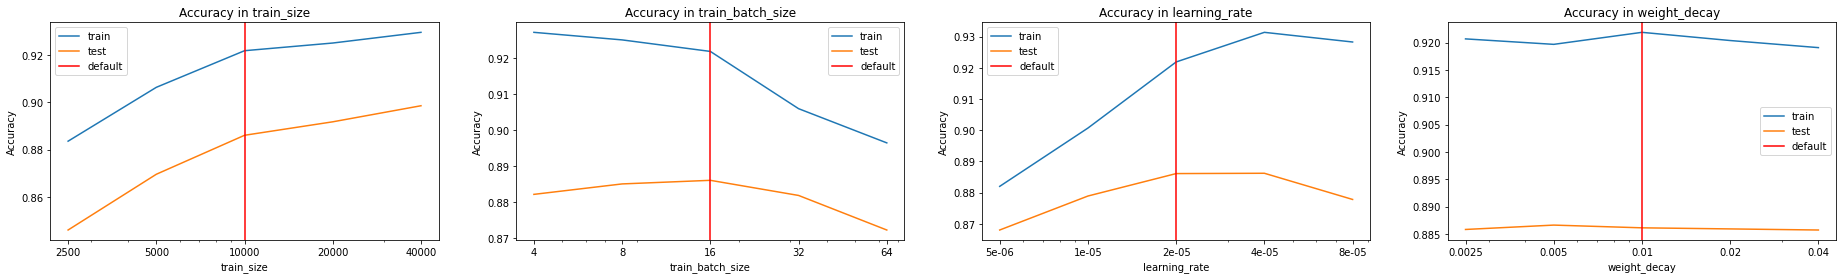

In [13]:
# sensitivity analysis

RUN_SENSITIVITY_ANALYSIS = False

sensitivity_params = {
    'train_size': [2500, 5000, 10000, 20000, 40000],
    'train_batch_size': [4, 8, 16, 32, 64],
    'learning_rate': [5e-6, 1e-5, 2e-5, 4e-5, 8e-5],
    'weight_decay': [0.0025, 0.005, 0.01, 0.02, 0.04]
}
default_n = 10000

if RUN_SENSITIVITY_ANALYSIS:
    for param_name, param_values in sensitivity_params.items():
        helpers.sensitivity_analysis(MODEL_CLASS, MODEL_ARGS, param_name, param_values, TRAIN_SIZE_XS)

helpers.plot_sensitivity_analysis_results(sensitivity_params)

In [14]:
# performance with default setting on extra small dataset
ts_sensitivity = pd.read_csv('sensitivity_analysis/train_size_sensitivity.csv', index_col=0)

benchmark_train_acc = ts_sensitivity.loc[TRAIN_SIZE_XS, 'train']
benchmark_test_acc = ts_sensitivity.loc[TRAIN_SIZE_XS, 'test']

print(f'Training accuracy: {benchmark_train_acc * 100:.2f}%')
print(f'Testing accuracy: {benchmark_test_acc * 100:.2f}%')

Training accuracy: 92.19%
Testing accuracy: 88.61%


In [ ]:
# default preprocessing

X_train_xs_normalized = helpers.normalizeTweets(X_train_xs)
X_test_xs_normalized = helpers.normalizeTweets(X_test_xs)

clf = MODEL_CLASS(MODEL_ARGS)
clf.fit(X_train_xs_normalized, y_train_xs)

y_train_normalized_hat = clf.predict(X_train_xs_normalized)
y_test_normalized_hat = clf.predict(X_test_xs_normalized)

train_normalized_acc = helpers.calc_clf_acc(y_train_xs, y_train_normalized_hat)
test_normalized_acc = helpers.calc_clf_acc(y_test_xs, y_test_normalized_hat)

print(f'Training accuracy: {train_normalized_acc * 100:.2f}%')
print(f'Testing accuracy: {test_normalized_acc * 100:.2f}%')

Training accuracy: 90.50%
Testing accuracy: 88.24%


In [ ]:
# simple ensembling

N_MODELS = 3

clf = models.Ensemble(
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    n_models=N_MODELS
)
clf.fit(X_train_xs, y_train_xs)

y_train_ensembled_hat = clf.predict(X_train_xs)
y_test_ensembled_hat = clf.predict(X_test_xs)

train_ensembled_acc = helpers.calc_clf_acc(y_train_xs, y_train_ensembled_hat)
test_ensembled_acc = helpers.calc_clf_acc(y_test_xs, y_test_ensembled_hat)

print(f'Training accuracy: {train_ensembled_acc * 100:.2f}%')
print(f'Testing accuracy: {test_ensembled_acc * 100:.2f}%')

Training accuracy: 92.25%
Testing accuracy: 88.78%


In [ ]:
# simple curriculum learning

clf = MODEL_CLASS(MODEL_ARGS)
clf.fit(X_train_xs, y_train_xs)

train_scores = helpers.get_confidence_scores(clf, X_train_xs, y_train_xs)
X_train_curr, y_train_curr = helpers.build_curriculum(X_train_xs, y_train_xs, train_scores)

clf = MODEL_CLASS(MODEL_ARGS)
clf.fit(X_train_curr, y_train_curr)

y_train_curriculum_hat = clf.predict(X_train_xs)
y_test_curriculum_hat = clf.predict(X_test_xs)

train_curriculum_acc = helpers.calc_clf_acc(y_train_xs, y_train_curriculum_hat)
test_curriculum_acc = helpers.calc_clf_acc(y_test_xs, y_test_curriculum_hat)

print(f'Training accuracy: {train_curriculum_acc * 100:.2f}%')
print(f'Testing accuracy: {test_curriculum_acc * 100:.2f}%')

Training accuracy: 91.44%
Testing accuracy: 88.37%


In [ ]:
# tensorflow model

tf_model_args = {
    'model_name': 'vinai/bertweet-base',
    'epochs': 1,
    'batch_size': 16,
    'val_size': 0.1,
    'learning_rate': 2e-5,
}

clf = TFBertweetClassifier(tf_model_args)
clf.fit(X_train_xs, y_train_xs)

y_train_tf_hat = clf.predict(X_train_xs)
y_test_tf_hat = clf.predict(X_test_xs)

train_tf_acc = helpers.calc_clf_acc(y_train_xs, y_train_tf_hat)
test_tf_acc = helpers.calc_clf_acc(y_test_xs, y_test_tf_hat)

print(f'Training accuracy: {train_tf_acc * 100:.2f}%')
print(f'Testing accuracy: {test_tf_acc * 100:.2f}%')

Training accuracy: 92.79%
Testing accuracy: 87.78%


In [ ]:
# dropping duplicates

X_train_xs_unique, y_train_xs_unique = helpers.drop_duplicates(X_train_xs, y_train_xs)

clf = MODEL_CLASS(MODEL_ARGS)
clf.fit(X_train_xs_unique, y_train_xs_unique)

y_train_unique_hat = clf.predict(X_train_xs)
y_test_unique_hat = clf.predict(X_test_xs)

train_unique_acc = helpers.calc_clf_acc(y_train_xs, y_train_unique_hat)
test_unique_acc = helpers.calc_clf_acc(y_test_xs, y_test_unique_hat)

print(f'Training accuracy: {train_normalized_acc * 100:.2f}%')
print(f'Testing accuracy: {test_normalized_acc * 100:.2f}%')

Training accuracy: 90.50%
Testing accuracy: 88.24%


In [24]:
# smiley analysis

X, y, _, _ = helpers.get_data(True, 42, 4e-7)
X_smileys, y_smileys = helpers.get_smileys_subset(X, y)
smileys_ratio = len(X_smileys) / len(X)
smileys_preds = helpers.smileys_predict(X_smileys)
smileys_acc = helpers.calc_clf_acc(y_smileys, smileys_preds)

print(f'Identified smileys for {smileys_ratio * 100:.2f}% of the data.')
print(f'Accuracy on this {smileys_ratio * 100:.2f}% subset is {smileys_acc * 100:.2f}%')

Identified smileys for 16.00% of the data.
Accuracy on this 16.00% subset is 98.28%


In [53]:
# smiley prediction updating

clf = MODEL_CLASS(MODEL_ARGS)
clf.fit(X_train_xs, y_train_xs)

y_train_hat = clf.predict(X_train_xs)
y_test_hat = clf.predict(X_test_xs)

y_train_smileys_hat = helpers.update_preds(X_train_xs, y_train_hat)
y_test_smileys_hat = helpers.update_preds(X_test_xs, y_test_hat)

train_smileys_acc = helpers.calc_clf_acc(y_train_xs, y_train_smileys_hat)
test_smileys_acc = helpers.calc_clf_acc(y_test_xs, y_test_smileys_hat)

print(f'Training accuracy: {train_smileys_acc * 100:.2f}%')
print(f'Testing accuracy: {test_smileys_acc * 100:.2f}%')

Training accuracy: 91.80%
Testing accuracy: 88.51%


In [61]:
# summary

rerun_experiments = False
if rerun_experiments:
    summary = pd.DataFrame()

    summary.loc['benchmark', 'train'] = benchmark_train_acc
    summary.loc['benchmark', 'test'] = benchmark_test_acc

    summary.loc['normalization', 'train'] = train_normalized_acc
    summary.loc['normalization', 'test'] = test_normalized_acc

    summary.loc['ensembling', 'train'] = train_ensembled_acc
    summary.loc['ensembling', 'test'] = test_ensembled_acc

    summary.loc['curriculum', 'train'] = train_curriculum_acc
    summary.loc['curriculum', 'test'] = test_curriculum_acc

    summary.loc['tensorflow', 'train'] = train_tf_acc
    summary.loc['tensorflow', 'test'] = test_tf_acc

    summary.loc['unique', 'train'] = train_unique_acc
    summary.loc['unique', 'test'] = test_unique_acc

    summary.loc['smileys', 'train'] = train_smileys_acc
    summary.loc['smileys', 'test'] = test_smileys_acc

    summary.to_csv('summary.csv')
else:
    summary = pd.read_csv('summary.csv', index_col=0)

summary = summary.sort_values(by='test', ascending=False).T
summary.applymap(lambda acc: f'{acc * 100:.2f}%')

,ensembling,benchmark,smileys,curriculum,normalization,unique,tensorflow
train,92.25%,92.19%,91.80%,91.44%,90.50%,91.70%,92.79%
test,88.78%,88.61%,88.51%,88.37%,88.24%,87.93%,87.78%


In [83]:
# optimization

space = {
    'learning_rate': hp.uniform('learning_rate', 2e-6, 2e-4),
    'batch_size': hp.uniform('batch_size', 8, 32),
}
best_params = helpers.optimize(MODEL_CLASS, MODEL_ARGS, X_train_xs, y_train_xs, space, 0.5, 4)